## Let's implement CCS from scratch.
This will deliberately be a simple (but less efficient) implementation to make everything as clear as possible.

In [1]:
!pip install numpy pandas matplotlib seaborn torch transformers[sentencepiece] datasets promptsource wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 KB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB

In [2]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Make sure to change the runtime type to GPU and install the relevant libraries above

In [4]:
from tqdm import tqdm
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForMaskedLM, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression

# Let's just try IMDB for simplicity
data = load_dataset("amazon_polarity")["test"]

# Here are a few different model options you can play around with:
# model_name = "deberta"
model_name = "gpt2-large"
# model_name = "t5"

# if you want to cache the model weights somewhere, you can specify that here
cache_dir = None

if model_name == "deberta":
    model_type = "encoder"
    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
    model = AutoModelForMaskedLM.from_pretrained("microsoft/deberta-v2-xxlarge", cache_dir=cache_dir)
    model.cuda()
elif model_name == "gpt-j":
    model_type = "decoder"
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
    model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B", cache_dir=cache_dir)
    model.cuda()
elif model_name == "t5":
    model_type = "encoder_decoder"
    tokenizer = AutoTokenizer.from_pretrained("t5-11b", cache_dir=cache_dir)
    model = AutoModelForSeq2SeqLM.from_pretrained("t5-11b", cache_dir=cache_dir)
    model.parallelize()  # T5 is big enough that we may need to run it on multiple GPUs
elif model_name.startswith("gpt2"):
    model_type = "decoder"
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
    model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir)
    model.cuda()
else:
    print("Not implemented!")

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Dataset amazon_polarity downloaded and prepared to /root/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## First let's write code for extracting hidden states given a model and text. 
How we do this exactly will depend on the type of model.

In [29]:
def get_encoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, truncation=True, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["hidden_states"]
    
    hs = hs_tuple[layer][0, 0].detach().cpu().numpy()  # TODO: the token position is arbitrary

    return hs

def get_encoder_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given an encoder-decoder model and some text, gets the encoder hidden states (in a given layer, by default the last) 
    on that input text (where the full text is given to the encoder).

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize
    encoder_text_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    decoder_text_ids = tokenizer("", return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(encoder_text_ids, decoder_input_ids=decoder_text_ids, output_hidden_states=True)

    # get the appropriate hidden states
    hs_tuple = output["encoder_hidden_states"]
    hs = hs_tuple[layer][0, -1].detach().cpu().numpy()  # TODO: the token position is arbitrary

    return hs

def get_decoder_hidden_states(model, tokenizer, input_text, layer=-1):
    """
    Given a decoder model and some text, gets the hidden states (in a given layer, by default the last) on that input text

    Returns a numpy array of shape (hidden_dim,)
    """
    # tokenize (adding the EOS token this time)
    input_ids = tokenizer(input_text + tokenizer.eos_token, return_tensors="pt").input_ids.to(model.device)

    # forward pass
    with torch.no_grad():
        output = model(input_ids, output_hidden_states=True)

    # get the last layer, last token hidden states
    hs_tuple = output["hidden_states"]
    if layer == "all":
      hs = np.concatenate([hs_tuple[l][0, -1].detach().cpu().numpy() for l in range(len(hs_tuple))])  # TODO: this takes all the hidden layers
    else:
      hs = hs_tuple[layer][0, -1].detach().cpu().numpy()  # the "-1" means the last token position

    return hs

def get_hidden_states(model, tokenizer, input_text, layer=-1, model_type="encoder"):
    fn = {"encoder": get_encoder_hidden_states, "encoder_decoder": get_encoder_decoder_hidden_states,
          "decoder": get_decoder_hidden_states}[model_type]

    return fn(model, tokenizer, input_text, layer=layer)

## Now let's write code for formatting data and for getting all the hidden states.

In [32]:
def format_imdb(text, label):
    """
    Given an imdb example ("text") and corresponding label (0 for negative, or 1 for positive), 
    returns a zero-shot prompt for that example (which includes that label as the answer).
    
    (This is just one example of a simple, manually created prompt.)
    """
    return "The following movie review expresses a " + ["negative", "positive"][label] + " sentiment:\n" + text


def get_hidden_states_many_examples(model, tokenizer, data, model_type, n=100, layer=-1):
    """
    Given an encoder-decoder model, a list of data, computes the contrast hidden states on n random examples.
    Returns numpy arrays of shape (n, hidden_dim) for each candidate label, along with a boolean numpy array of shape (n,)
    with the ground truth labels
    
    This is deliberately simple so that it's easy to understand, rather than being optimized for efficiency
    """
    # setup
    model.eval()
    all_neg_hs, all_pos_hs, all_gt_labels = [], [], []

    # loop
    for _ in tqdm(range(n)):
        # for simplicity, sample a random example until we find one that's a reasonable length
        # (most examples should be a reasonable length, so this is just to make sure)
        while True:
            idx = np.random.randint(len(data))
            text, true_label = data[idx]["content"], data[idx]["label"]
            # the actual formatted input will be longer, so include a bit of a marign
            if len(tokenizer(text)) < 360:  
                break
                
        # get hidden states
        neg_hs = get_hidden_states(model, tokenizer, format_imdb(text, 0), model_type=model_type, layer=layer)
        pos_hs = get_hidden_states(model, tokenizer, format_imdb(text, 1), model_type=model_type, layer=layer)

        # collect
        all_neg_hs.append(neg_hs)
        all_pos_hs.append(pos_hs)
        all_gt_labels.append(true_label)

    all_neg_hs = np.stack(all_neg_hs)
    all_pos_hs = np.stack(all_pos_hs)
    all_gt_labels = np.stack(all_gt_labels)

    return all_neg_hs, all_pos_hs, all_gt_labels

In [33]:
layer = -1
neg_hs, pos_hs, y = get_hidden_states_many_examples(model, tokenizer, data, model_type, n=300, layer=layer)

100%|██████████| 300/300 [00:36<00:00,  8.18it/s]


## Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if logistic regression accuracy is bad, there's no hope of CCS doing well.

In [34]:
# let's create a simple 50/50 train split (the data is already randomized)
n = len(y)
neg_hs = neg_hs[:, -1280:]
pos_hs = pos_hs[:, -1280:]
neg_hs_train, neg_hs_test = neg_hs[:n//2], neg_hs[n//2:]
pos_hs_train, pos_hs_test = pos_hs[:n//2], pos_hs[n//2:]
y_train, y_test = y[:n//2], y[n//2:]

# for simplicity we can just take the difference between positive and negative hidden states
# (concatenating also works fine)
x_train = neg_hs_train - pos_hs_train
x_test = neg_hs_test - pos_hs_test

lr = LogisticRegression(class_weight="balanced")
lr.fit(x_train, y_train)
lr_acc = lr.score(x_test, y_test)
print("Logistic regression accuracy: {}".format(lr_acc))

Logistic regression accuracy: 0.8333333333333334


In [35]:
np.std(lr.predict(x_test) == y_test) / np.sqrt(len(y_test))

0.03042903097250923

## Now let's try CCS

In [36]:
class MLPProbe(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.linear1 = nn.Linear(d, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        o = self.linear2(h)
        return torch.sigmoid(o)

class CCS(object):
    def __init__(self, x0, x1, nepochs=1000, ntries=10, lr=1e-3, batch_size=-1, 
                 verbose=False, device="cuda", linear=True, weight_decay=0.01, 
                 var_normalize=False, optimizer="SGD"):
        # data
        self.var_normalize = var_normalize
        self.x0 = self.normalize(x0)
        self.x1 = self.normalize(x1)
        self.d = self.x0.shape[-1]

        # training
        self.optimizer = optimizer
        self.nepochs = nepochs
        self.ntries = ntries
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # probe
        self.linear = linear
        self.probe = self.initialize_probe()
        self.best_probe = copy.deepcopy(self.probe)

        
    def initialize_probe(self):
        if self.linear:
            self.probe = nn.Sequential(nn.Linear(self.d, 1), nn.Sigmoid())
        else:
            self.probe = MLPProbe(self.d)
        self.probe.to(self.device)    


    def normalize(self, x):
        """
        Mean-normalizes the data x (of shape (n, d))
        If self.var_normalize, also divides by the standard deviation
        """
        normalized_x = x - x.mean(axis=0, keepdims=True)
        if self.var_normalize:
            normalized_x /= normalized_x.std(axis=0, keepdims=True)

        return normalized_x

        
    def get_tensor_data(self):
        """
        Returns x0, x1 as appropriate tensors (rather than np arrays)
        """
        x0 = torch.tensor(self.x0, dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.x1, dtype=torch.float, requires_grad=False, device=self.device)
        return x0, x1
    

    def get_loss(self, p0, p1):
        """
        Returns the CCS loss for two probabilities each of shape (n,1) or (n,)
        """
        informative_loss = (torch.min(p0, p1)**2).mean(0)
        consistent_loss = ((p0 - (1-p1))**2).mean(0)
        return informative_loss + consistent_loss


    def get_acc(self, x0_test, x1_test, y_test):
        """
        Computes accuracy for the current parameters on the given test inputs
        """
        x0 = torch.tensor(self.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        acc = (predictions == y_test).mean()
        acc = max(acc, 1 - acc)

        return acc
    
        
    def train(self):
        """
        Does a single training run of nepochs epochs
        """
        x0, x1 = self.get_tensor_data()
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]
        
        # set up optimizer
        if self.optimizer == "AdamW":
          optimizer = torch.optim.AdamW(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer == "SGD":
          optimizer = torch.optim.SGD(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        batch_size = len(x0) if self.batch_size == -1 else self.batch_size
        nbatches = len(x0) // batch_size

        # Start training (full batch)
        for epoch in range(self.nepochs):
            for j in range(nbatches):
                x0_batch = x0[j*batch_size:(j+1)*batch_size]
                x1_batch = x1[j*batch_size:(j+1)*batch_size]
            
                # probe
                p0, p1 = self.probe(x0_batch), self.probe(x1_batch)

                # get the corresponding loss
                loss = self.get_loss(p0, p1)

                # update the parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            wandb.log({"loss": loss.detach().cpu().numpy()})

        return loss.detach().cpu().item()
    
    def repeated_train(self):
        best_loss = np.inf
        for train_num in range(self.ntries):
            self.initialize_probe()
            loss = self.train()
            if loss < best_loss:
                self.best_probe = copy.deepcopy(self.probe)
                best_loss = loss

        return best_loss

In [48]:
import wandb
wandb.init(project="ccs", entity="latent-knowledge")

ccs_acc,█▁▃▄▃▂▄▆▆▁▄
logistic_regression_accuracy,▁
loss,▄▁▁▁█▁▁▁▇▁▁▁▆▁▁▁▄▁▁▁▃▁▁▁▃▁▁▁▅▁▁▁▄▁▁▁▃▁▁▁
ccs_acc,0.58267
logistic_regression_accuracy,0.83333
loss,0.19998


In [49]:
ccs_params = {
  "lr": 1e-3,
  "optimizer": "AdamW",
  "ntries": 1,
  "weight_decay": 0.01,
  "nepochs": 10_000,
  "batch_size": -1,
  "linear": True,
  "var_normalize": False
}
wandb.config = {
  "model_name": model_name,
  "model_type": model_type,
  "n": n,
  "layer": layer
}.update(ccs_params)

In [50]:
ccs_accs = []
learned_params = []
n_trials = 10
for trial in tqdm(range(n_trials), total=n_trials):  # Train CCS without any labels
  ccs = CCS(neg_hs_train, pos_hs_train, **ccs_params)
  ccs.repeated_train()

  # Evaluate
  ccs_acc = ccs.get_acc(neg_hs_test, pos_hs_test, y_test)
  ccs_accs.append(ccs_acc)

  # Store the solution
  params = np.concatenate([vec.flatten().detach().cpu().numpy() for vec in ccs.probe.parameters()])
  learned_params.append(params)
  print("CCS accuracy: {}".format(ccs_acc))
  wandb.log({"ccs_acc": ccs_acc,
           "parameters": params})
print(np.mean(ccs_accs), np.std(ccs_accs) / np.sqrt(len(ccs_accs)))

 10%|█         | 1/10 [00:26<03:58, 26.53s/it]

CCS accuracy: 0.5066666666666667


 20%|██        | 2/10 [00:52<03:30, 26.35s/it]

CCS accuracy: 0.5066666666666667


 30%|███       | 3/10 [01:20<03:08, 26.88s/it]

CCS accuracy: 0.5


 40%|████      | 4/10 [01:46<02:40, 26.80s/it]

CCS accuracy: 0.5


 50%|█████     | 5/10 [02:14<02:15, 27.06s/it]

CCS accuracy: 0.5


 60%|██████    | 6/10 [02:40<01:46, 26.73s/it]

CCS accuracy: 0.5


 70%|███████   | 7/10 [03:06<01:19, 26.58s/it]

CCS accuracy: 0.5


 80%|████████  | 8/10 [03:32<00:52, 26.43s/it]

CCS accuracy: 0.5


 90%|█████████ | 9/10 [03:58<00:26, 26.12s/it]

CCS accuracy: 0.5


100%|██████████| 10/10 [04:24<00:00, 26.42s/it]

CCS accuracy: 0.5
0.5013333333333334 0.0008432740427115732


In [51]:
print(np.mean(ccs_accs), np.std(ccs_accs))

0.5013333333333334 0.002666666666666684


Text(33.0, 0.5, 'training run')

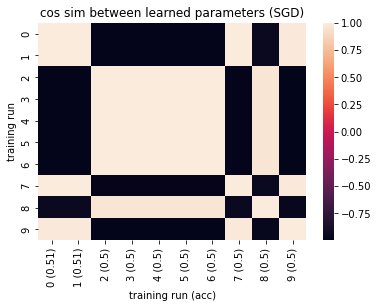

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = np.corrcoef(learned_params)
normalized = np.array(learned_params)
normalized /= np.sqrt(np.sum(normalized**2, axis=1, keepdims=True))
dots = np.dot(normalized, normalized.T)
sns.heatmap(dots, xticklabels=[f"{i} ({round(ccs_accs[i], 2)})" for i in range(10)], yticklabels=range(10))
plt.title("cos sim between learned parameters (SGD)")
plt.xlabel("training run (acc)")
plt.ylabel("training run")

In [53]:
parameters = np.concatenate([vec.flatten().detach().cpu().numpy() for vec in ccs.probe.parameters()])
wandb.log({"corrleations": corr,
           "cosine_similarities": dots,
           "ccs_acc": np.mean(ccs_accs),
           "logistic_regression_accuracy": lr_acc})

In [54]:
learned_params[0]

array([ 7.9501033 , -3.0442882 ,  7.9685416 , ...,  7.4977865 ,
       -7.6290617 , -0.23202738], dtype=float32)

In [55]:
learned_params[1]

array([ 8.071482  , -2.3497508 ,  8.104756  , ...,  7.716285  ,
       -7.808649  , -0.23234399], dtype=float32)

In [56]:
x0_test, x1_test = ccs.get_tensor_data()
x0 = torch.tensor(ccs.normalize(x0_test), dtype=torch.float, requires_grad=False, device=ccs.device)
x1 = torch.tensor(ccs.normalize(x1_test), dtype=torch.float, requires_grad=False, device=ccs.device)
with torch.no_grad():
    p0, p1 = ccs.best_probe(x0), ccs.best_probe(x1)

<ipython-input-56-b2cb003421a6>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(ccs.normalize(x0_test), dtype=torch.float, requires_grad=False, device=ccs.device)
<ipython-input-56-b2cb003421a6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(ccs.normalize(x1_test), dtype=torch.float, requires_grad=False, device=ccs.device)


In [57]:
p1

tensor([[0.6203],
        [0.6684],
        [0.3133],
        [0.1798],
        [0.7706],
        [0.2824],
        [0.3216],
        [0.0858],
        [0.1848],
        [0.3135],
        [0.6720],
        [0.1423],
        [0.8208],
        [0.0621],
        [0.9498],
        [0.6671],
        [0.3418],
        [0.8565],
        [0.9082],
        [0.2927],
        [0.5079],
        [0.9473],
        [0.1727],
        [0.3764],
        [0.7065],
        [0.2972],
        [0.6761],
        [0.7682],
        [0.1981],
        [0.2780],
        [0.1641],
        [0.9769],
        [0.9131],
        [0.9602],
        [0.5249],
        [0.0927],
        [0.1017],
        [0.9335],
        [0.9189],
        [0.8840],
        [0.2106],
        [0.3194],
        [0.6910],
        [0.8945],
        [0.8698],
        [0.0526],
        [0.3020],
        [0.8860],
        [0.9163],
        [0.2516],
        [0.6911],
        [0.0458],
        [0.9104],
        [0.3441],
        [0.2197],
        [0